# Imputation stability

We explore various expectile imputation strategies and their stability through repeated imputation.

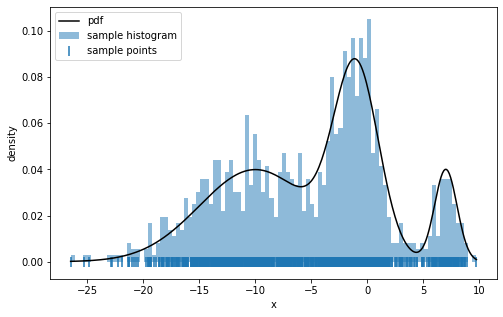

In [6]:
import importlib

import numpy as np
import matplotlib.pyplot as plt

import tqdm.notebook as tqdm

from util.expectiles import expectile, tauspace
from util.gmm import EXAMPLE

import imputers
imputers = importlib.reload(imputers) # reload

SAMPLE, GMM_X, GMM_Y = EXAMPLE(1000, figsize=(8, 5))

## Stability experiments

In [2]:
def shift_experiment(taus, imputer, sample=SAMPLE, n_iterations=100, n_samples=None,
                     cm=plt.cm.gist_rainbow, bins=None, **kwargs):
    if n_samples is None: n_samples = len(sample)
    print("imputation shift experiment with", imputer)
    print("n samples:    ", n_samples)
    print("n iterations: ", n_iterations)
    # record more expectiles than those provided
    full_taus = tauspace(999)
    expectiles = np.ndarray((n_iterations+1, 999))
    samples = np.ndarray((n_iterations, n_samples))
    sample0 = sample
    fits = []
    # perform experiment:
    expectiles[0] = expectile(sample, full_taus)
    for i in tqdm.trange(1, n_iterations+1):
        imputer.fit(expectile(sample, taus), taus, **kwargs)
        fits.append((imputer.τ, imputer.ε))
        sample = imputer.sample(n_samples)
        expectiles[i] = expectile(sample, full_taus)
        samples[i-1] = sample
    imputer.fit(expectile(sample, taus), taus, **kwargs)
    fits.append((imputer.τ, imputer.ε))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.set_xlabel("asymmetry (τ)")
    ax1.set_ylabel("expectile (ε)")
    ax2.set_xlabel("sample point")
    ax2.set_ylabel("sample density")
    # visualise:
    if bins is None: bins=np.linspace(samples.min(), samples.max(), 100)
    for i in range(0, n_iterations+1, max(1, n_iterations//5)):
        ax1.plot(full_taus, expectiles[i],
                 label=f'after {i} iterations', color=cm(i/n_iterations))
        try:
            ax1.scatter(*fits[i], marker="x", alpha=10/len(fits[i][0]),
                        color=cm(i/n_iterations))
        except:
            pass
        ax2.hist(samples[i-1] if i else sample0,
                 density=True, alpha=0.5, bins=bins,
                 label=f'after {i} iterations', color=cm(i/n_iterations))
    ax1.legend()
    ax2.legend()
    plt.show()
    fig, ax3 = plt.subplots(1, 1, figsize=(14, 5))
    ax3.set_xlabel("number of iterations")
    ax3.set_ylabel("expectile (ε)")
    for i in [998, 899, 799, 699, 599, 499, 399, 299, 199, 99, 0]:
        ax3.plot(expectiles[:, i], marker='x', color=cm(i/999), label=f'τ={full_taus[i]:.4f}')
    for t in range(0, n_iterations+1):
        x = samples[t-1] if t else sample0
        ax3.scatter(t*np.ones_like(x), x, alpha=6/x.size, marker='.', color='k')
    plt.legend(loc=(1.01, 0.1))
    plt.show()

### Deepmind's Naive imputer

imputation shift experiment with NaiveImputer()
n samples:     1000
n iterations:  20


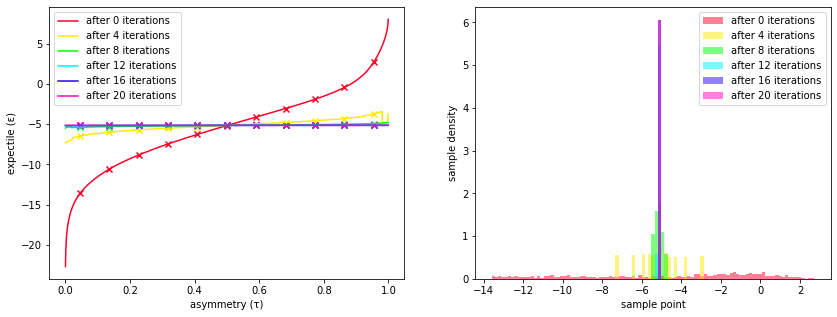

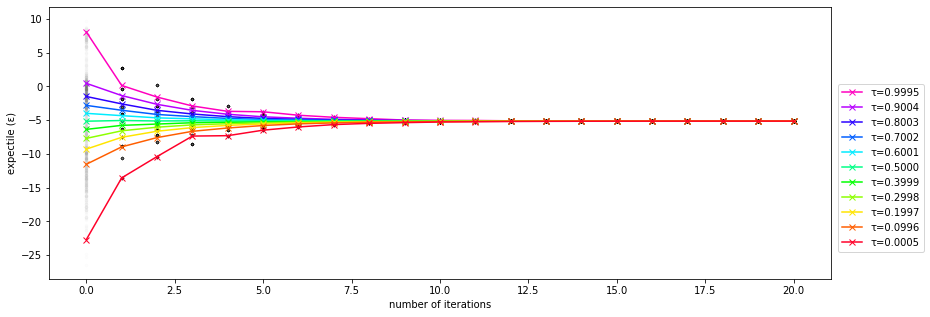

imputation shift experiment with NaiveImputer()
n samples:     1000
n iterations:  20


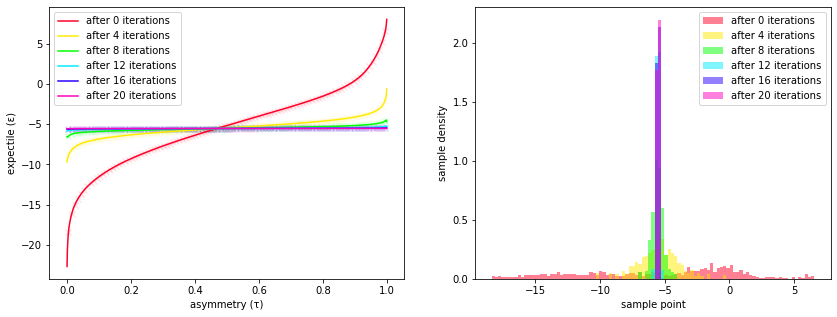

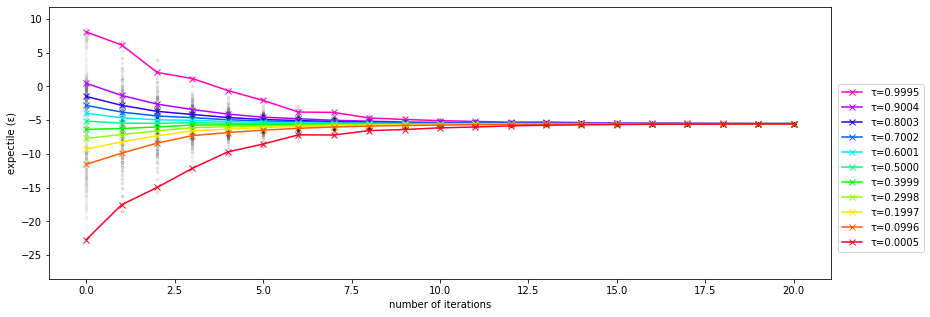

imputation shift experiment with NaiveImputer()
n samples:     1000
n iterations:  20


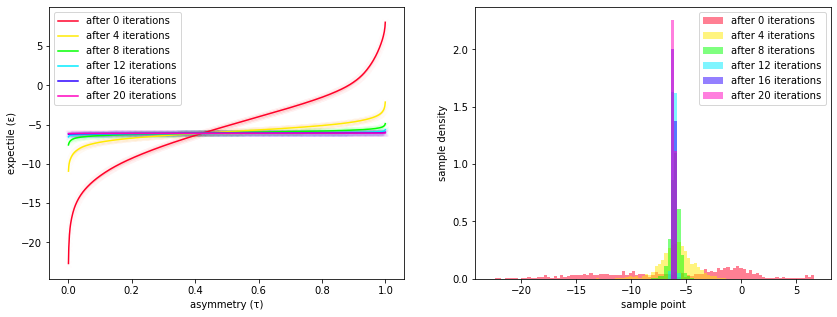

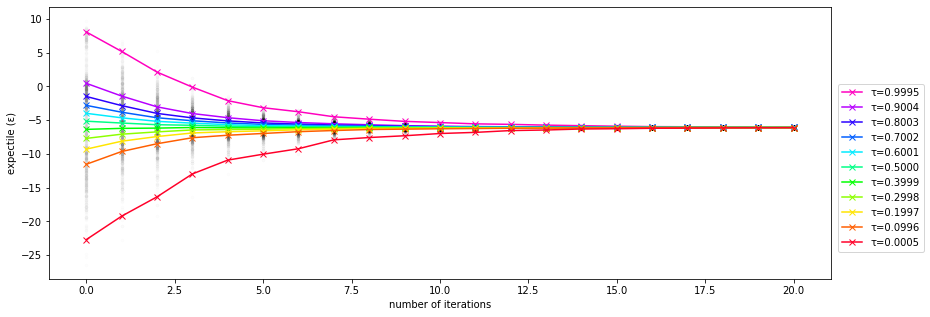

In [26]:
shift_experiment(tauspace(11),   imputers.NaiveImputer(), n_iterations=20)
shift_experiment(tauspace(101),  imputers.NaiveImputer(), n_iterations=20)
shift_experiment(tauspace(1001), imputers.NaiveImputer(), n_iterations=20)

### Deepmind's Optimisation-based imputer

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     11
n iterations:  20


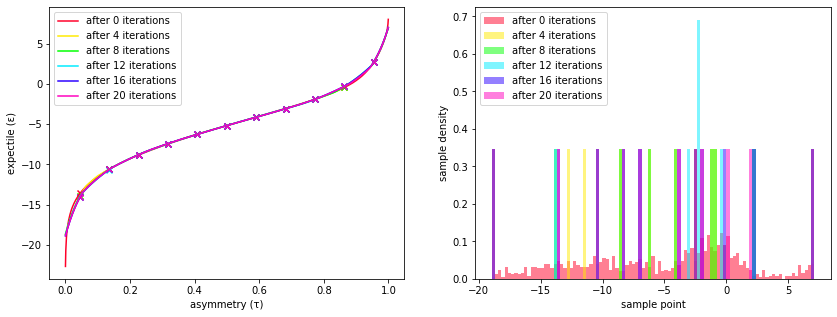

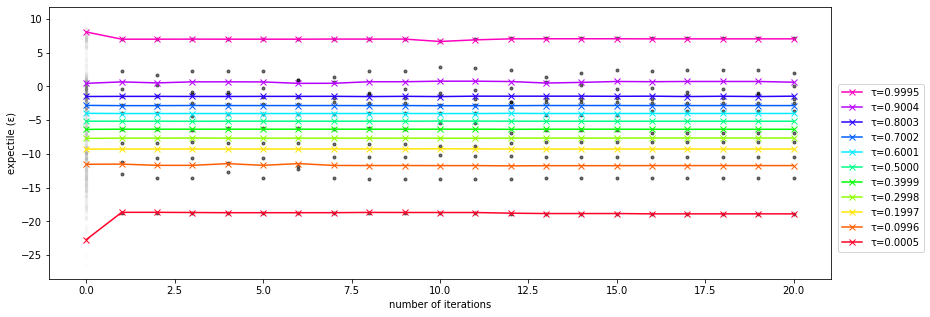

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     11
n iterations:  1000


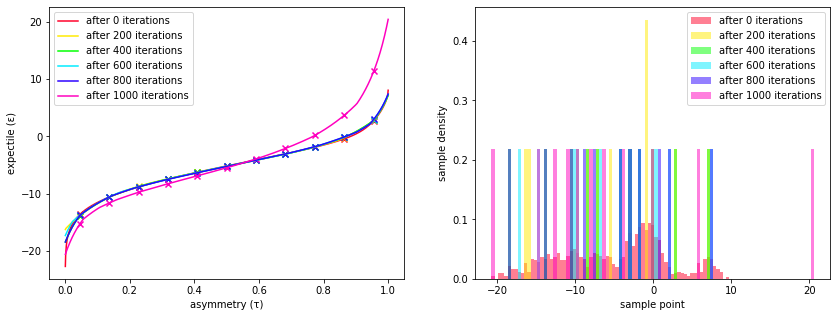

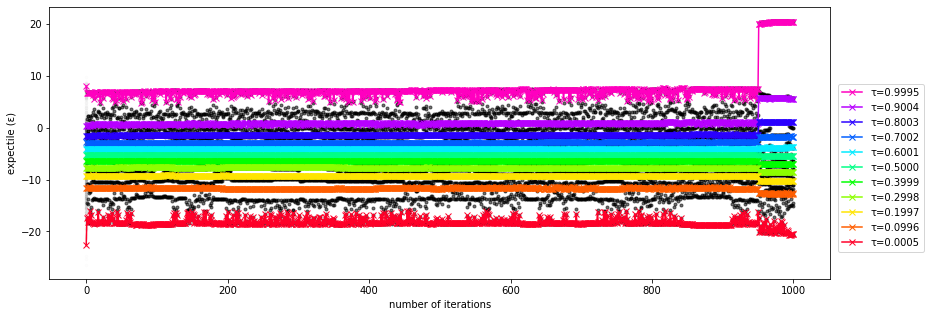

In [27]:
shift_experiment(tauspace(11), imputers.OptBasedImputer(), n_iterations=20,   n_samples=11)
shift_experiment(tauspace(11), imputers.OptBasedImputer(), n_iterations=1000, n_samples=11)

Note to self: very stable! BUT occasionally even this method has a bad imputation and jumps to a wildly different distribution.

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     101
n iterations:  20


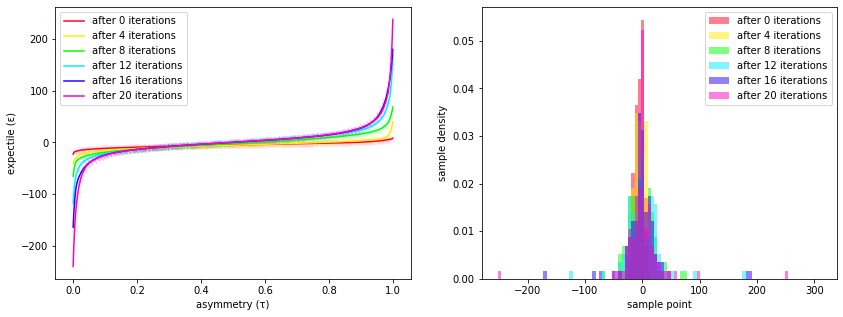

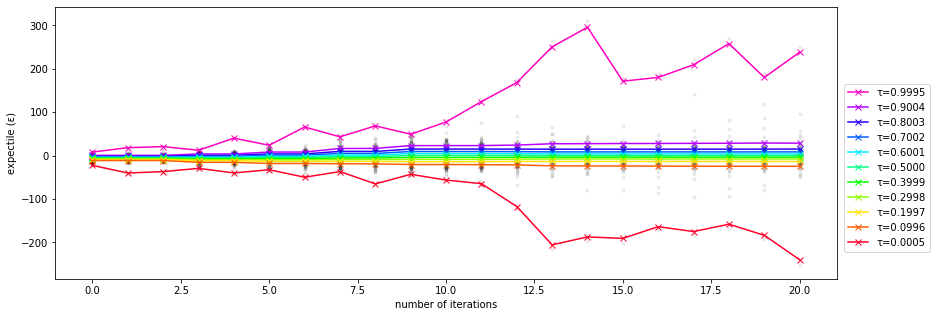

In [28]:
shift_experiment(tauspace(101), imputers.OptBasedImputer(), n_iterations=20, n_samples=101)

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     101
n iterations:  20


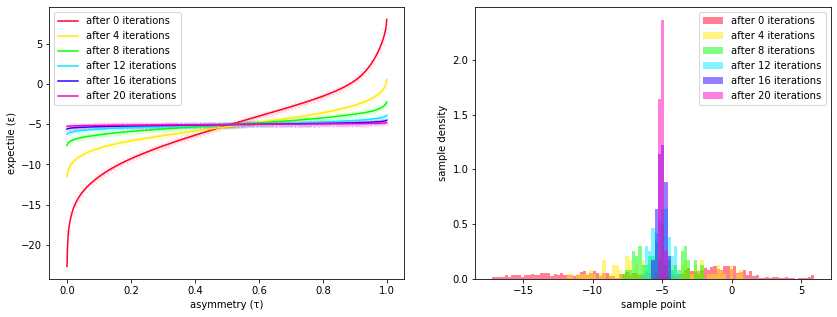

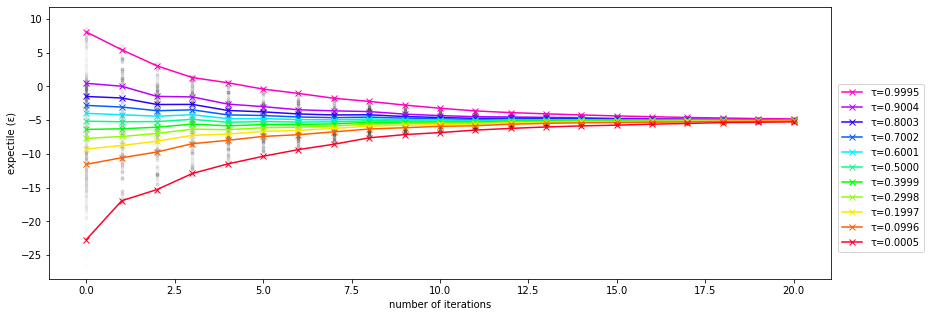

In [30]:
shift_experiment(tauspace(101), imputers.OptBasedImputer(), n_iterations=20, n_samples=101)

When we increase the number of taus, the optimiser doesn't do as reliable a job at recovering the sample. We see either collapse or explosion (... why one or the other, and not both at once?)

### 'Direct' imputer

imputation shift experiment with DirectImputer(self.smooth_invert=False, self.exp_tails=False)
n samples:     1000
n iterations:  20


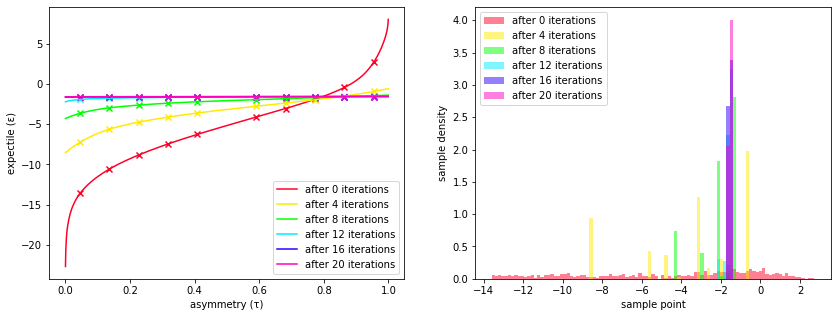

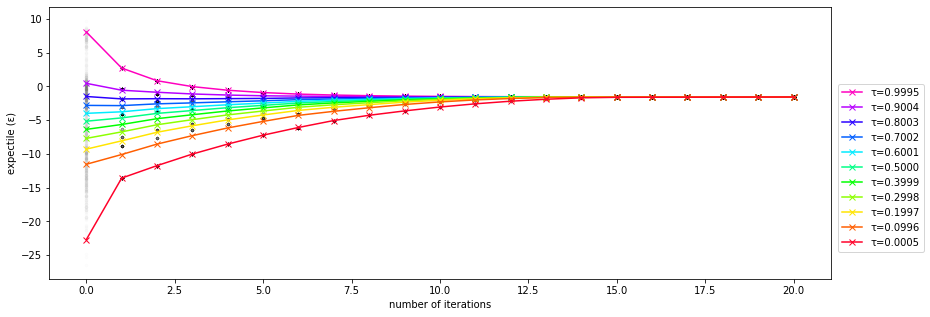

imputation shift experiment with DirectImputer(self.smooth_invert=False, self.exp_tails=False)
n samples:     1000
n iterations:  20


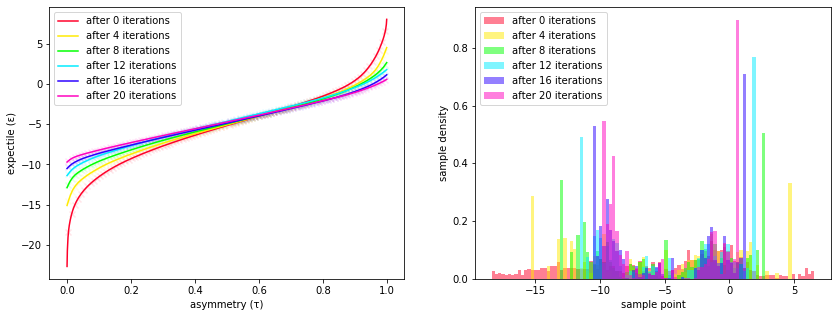

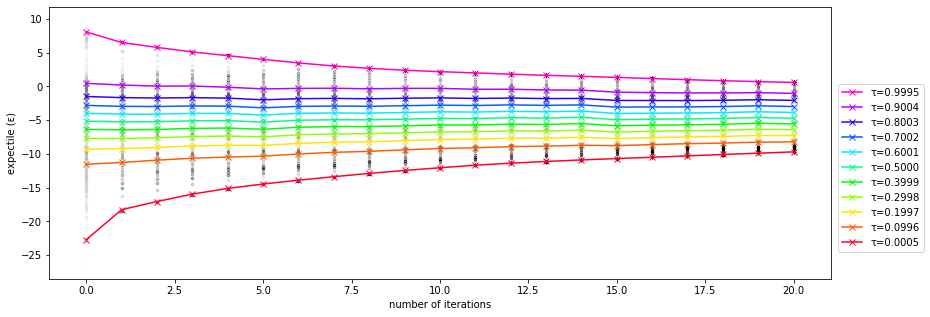

In [3]:
shift_experiment(tauspace(11),  imputers.DirectImputer(), n_iterations=20)
shift_experiment(tauspace(101), imputers.DirectImputer(), n_iterations=20)

imputation shift experiment with DirectImputer(self.smooth_invert=True, self.exp_tails=True)
n samples:     1000
n iterations:  20


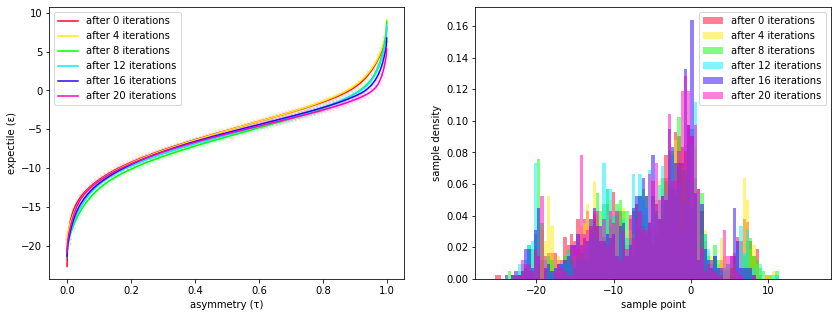

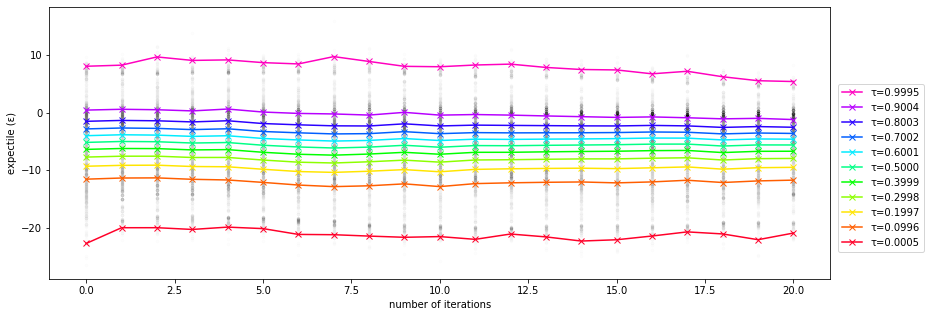

imputation shift experiment with DirectImputer(self.smooth_invert=True, self.exp_tails=True)
n samples:     1000
n iterations:  1000


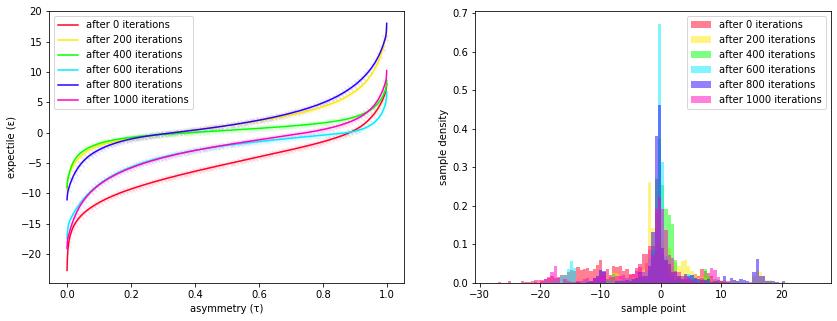

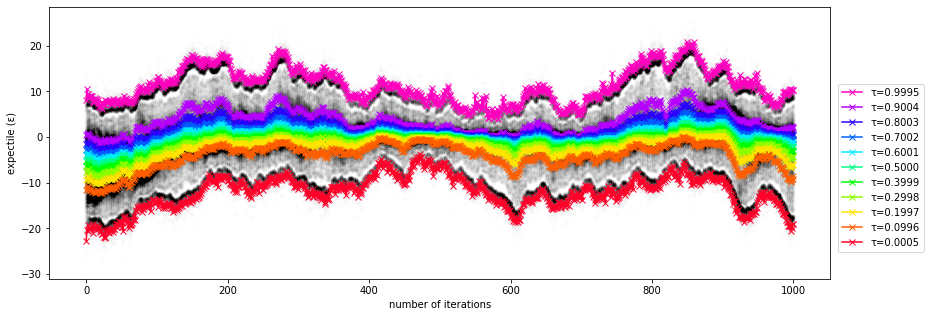

In [4]:
shift_experiment(tauspace(101), imputers.DirectImputer(smooth_invert=True, exp_tails=True), n_iterations=20)
shift_experiment(tauspace(101), imputers.DirectImputer(smooth_invert=True, exp_tails=True), n_iterations=1000)

### Direct imputer with logit-linear interpolation and extrapolation of CDF

imputation shift experiment with InterpolatingImputer()
n samples:     1000
n iterations:  20


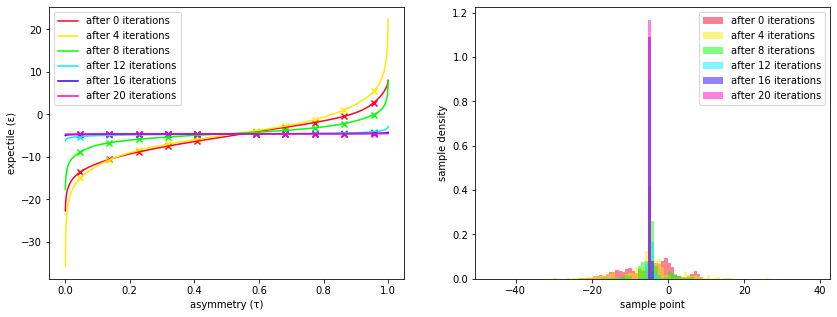

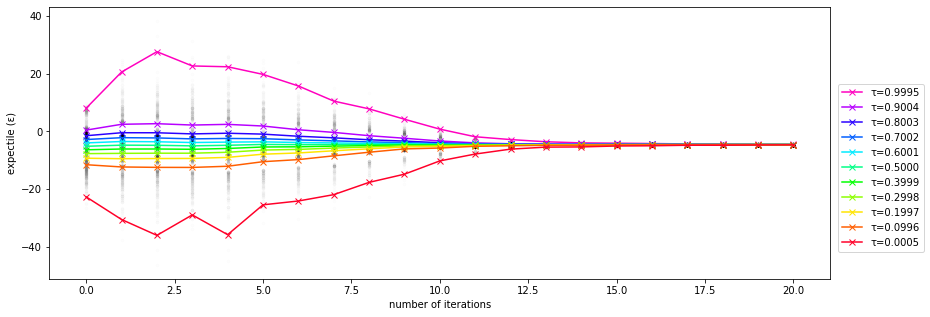

In [37]:
shift_experiment(tauspace(11), imputers.InterpolatingImputer(), n_iterations=20)

imputation shift experiment with InterpolatingImputer()
n samples:     1000
n iterations:  20


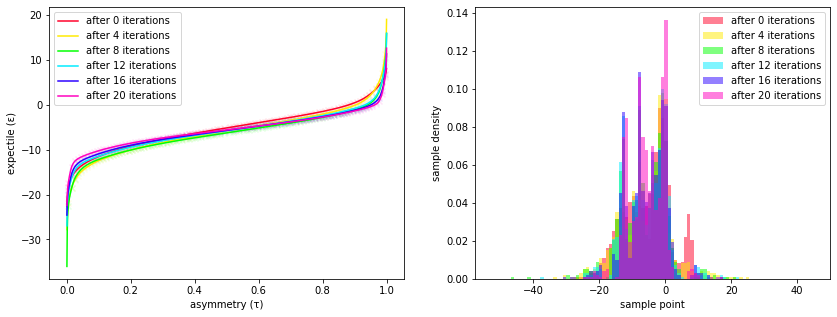

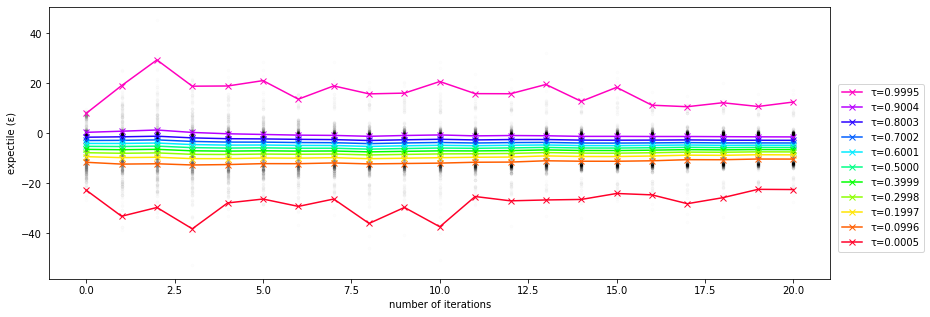

imputation shift experiment with InterpolatingImputer()
n samples:     1000
n iterations:  100


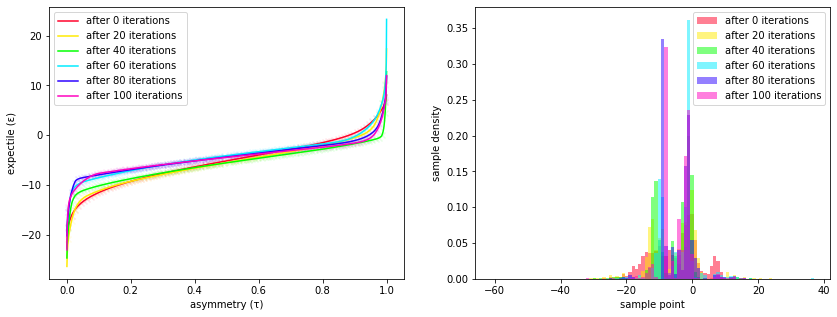

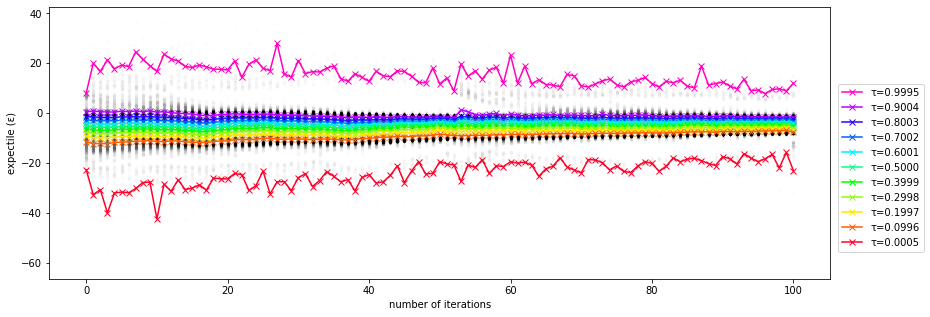

In [38]:
shift_experiment(tauspace(101), imputers.InterpolatingImputer(), n_iterations=20)
shift_experiment(tauspace(101), imputers.InterpolatingImputer(), n_iterations=100)

### Fit a logit polynomial to the expectile function

imputation shift experiment with PolyLogitImputer(self.degree=3)
n samples:     101
n iterations:  20


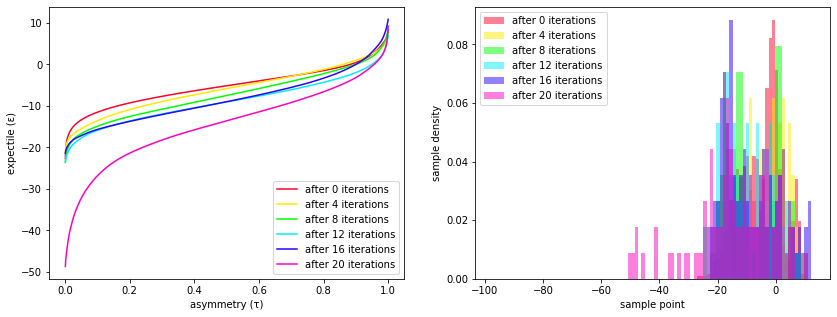

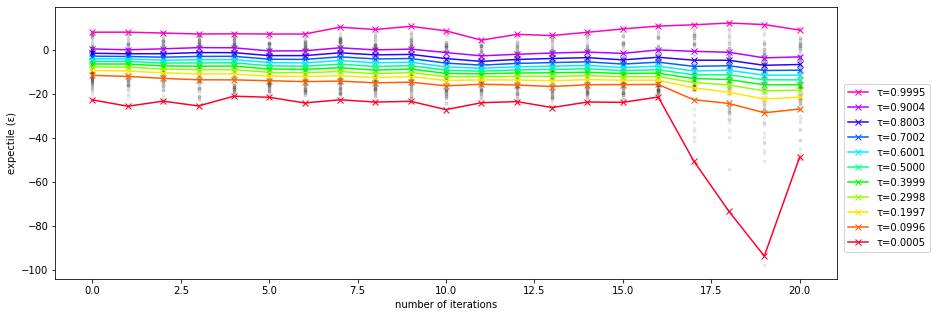

In [17]:
shift_experiment(tauspace(101), imputers.PolyLogitImputer(batch_size=None), n_iterations=20, n_samples=101)

imputation shift experiment with PolyLogitImputer(self.degree=7)
n samples:     1000
n iterations:  50


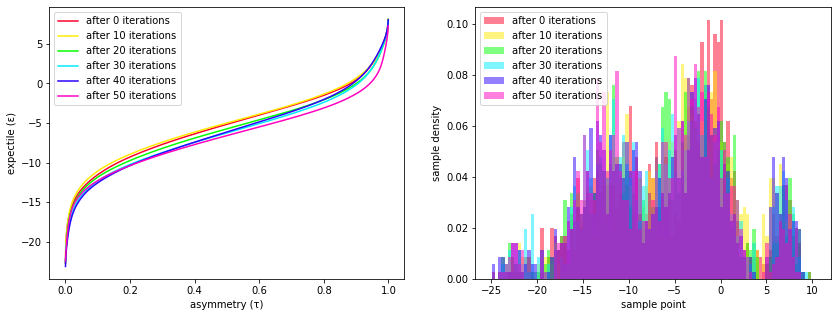

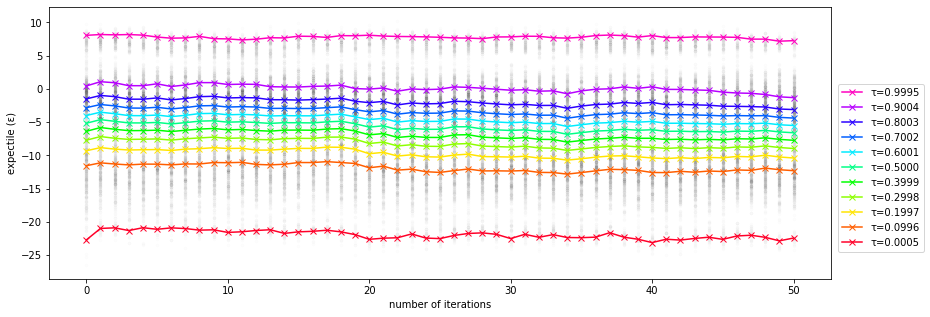

In [18]:
shift_experiment(tauspace(101), imputers.PolyLogitImputer(degree=7, batch_size=100), n_iterations=50, n_samples=1000)

### Fit a logit polynomial to the expectile function (and subsample)

imputation shift experiment with PolyLogitInterpImputer(self.degree=3)
n samples:     1000
n iterations:  100


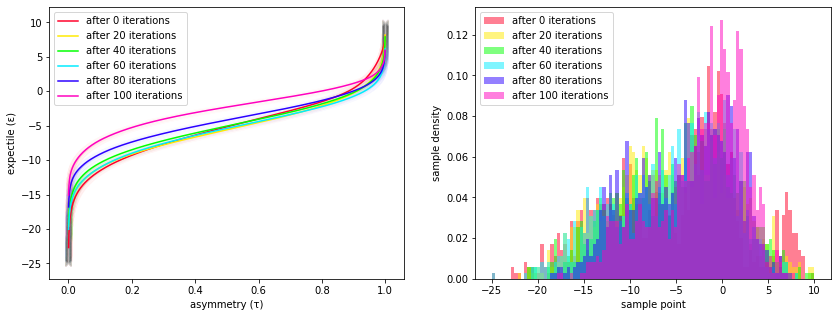

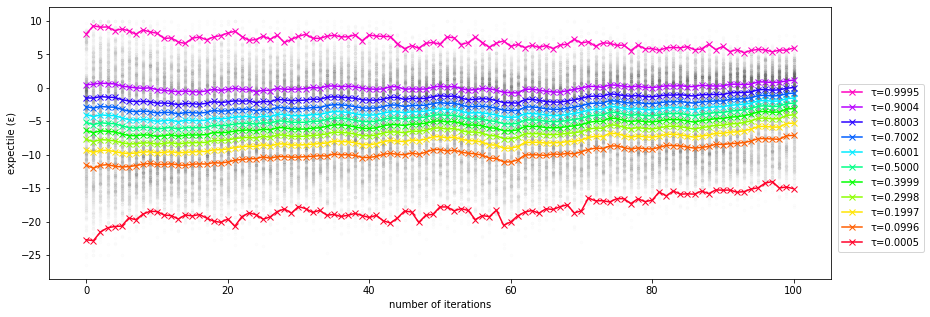

In [9]:
shift_experiment(tauspace(101), imputers.PolyLogitInterpImputer(), n_iterations=100)

imputation shift experiment with PolyLogitInterpImputer(self.degree=3)
n samples:     1000
n iterations:  1000


/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1061: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1061: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1062: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1062: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: invalid value encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.8/site

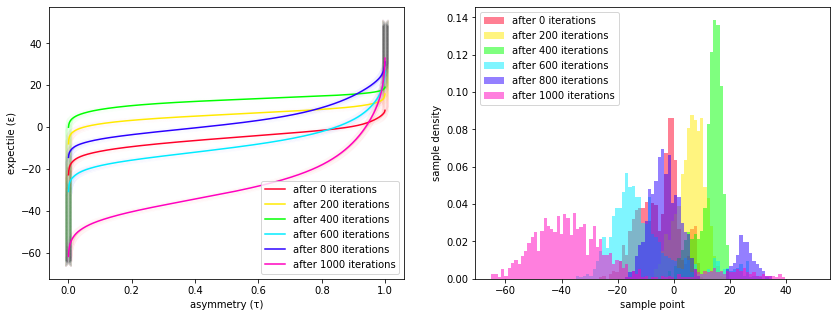

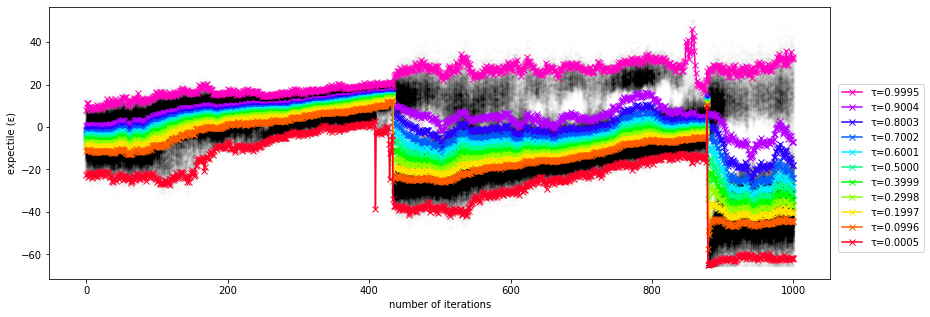

In [11]:
shift_experiment(tauspace(101), imputers.PolyLogitInterpImputer(x=np.linspace(-65, 50, 2000)), n_iterations=1000)

**NOTE:** In the above there are some implicit range assumptions I snuck into the imputer based on knownlede of this distribution! Be careful!